### Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Read csv file

In [2]:
df=pd.read_csv('data/time_series_covid19_confirmed_global.csv')

In [3]:
df.shape

(275, 466)

In [4]:
df.iloc[0:5, 0:5]

,Province/State,Country/Region,Lat,Long,1/22/20
0,NaN,Afghanistan,33.93911,67.709953,0
1,NaN,Albania,41.15330,20.168300,0
2,NaN,Algeria,28.03390,1.659600,0
3,NaN,Andorra,42.50630,1.521800,0
4,NaN,Angola,-11.20270,17.873900,0


### Wide to long Dataframe

In [5]:
df_melt=pd.melt(df, id_vars=['Province/State', 'Country/Region', 'Lat', 
                             'Long'], var_name='date', 
                value_name='confirmed_case')
df_melt.head()

,Province/State,Country/Region,Lat,Long,date,confirmed_case
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


In [6]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127050 entries, 0 to 127049
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Province/State  39732 non-null   object 
 1   Country/Region  127050 non-null  object 
 2   Lat             126126 non-null  float64
 3   Long            126126 non-null  float64
 4   date            127050 non-null  object 
 5   confirmed_case  127050 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 5.8+ MB


In [7]:
df_melt['date']=pd.to_datetime(df_melt.date)

In [8]:
df_melt.head()

,Province/State,Country/Region,Lat,Long,date,confirmed_case
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0
1,NaN,Albania,41.15330,20.168300,2020-01-22,0
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0


In [9]:
df_melt.columns=df_melt.columns.str.replace('/','_')

In [10]:
df_melt.columns

Index(['Province_State', 'Country_Region', 'Lat', 'Long', 'date',
       'confirmed_case'],
      dtype='object')

### Bangladesh

In [11]:
df_bd=df_melt[df_melt.Country_Region=='Bangladesh']
df_bd.shape

(462, 6)

In [12]:
df_bd.head()

,Province_State,Country_Region,Lat,Long,date,confirmed_case
20,NaN,Bangladesh,23.685,90.3563,2020-01-22,0
295,NaN,Bangladesh,23.685,90.3563,2020-01-23,0
570,NaN,Bangladesh,23.685,90.3563,2020-01-24,0
845,NaN,Bangladesh,23.685,90.3563,2020-01-25,0
1120,NaN,Bangladesh,23.685,90.3563,2020-01-26,0


In [13]:
df_bd['daily_case']=df_bd.confirmed_case.diff().fillna(0)

<ipython-input-13-9fde01ad6944>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bd['daily_case']=df_bd.confirmed_case.diff().fillna(0)


In [14]:
df_bd.tail()

,Province_State,Country_Region,Lat,Long,date,confirmed_case,daily_case
125695,NaN,Bangladesh,23.685,90.3563,2021-04-23,739703,3629.0
125970,NaN,Bangladesh,23.685,90.3563,2021-04-24,742400,2697.0
126245,NaN,Bangladesh,23.685,90.3563,2021-04-25,745322,2922.0
126520,NaN,Bangladesh,23.685,90.3563,2021-04-26,748628,3306.0
126795,NaN,Bangladesh,23.685,90.3563,2021-04-27,751659,3031.0


In [15]:
df_bd.daily_case.max()

7626.0

Text(0, 0.5, 'Number of Confirmed Cases\n')

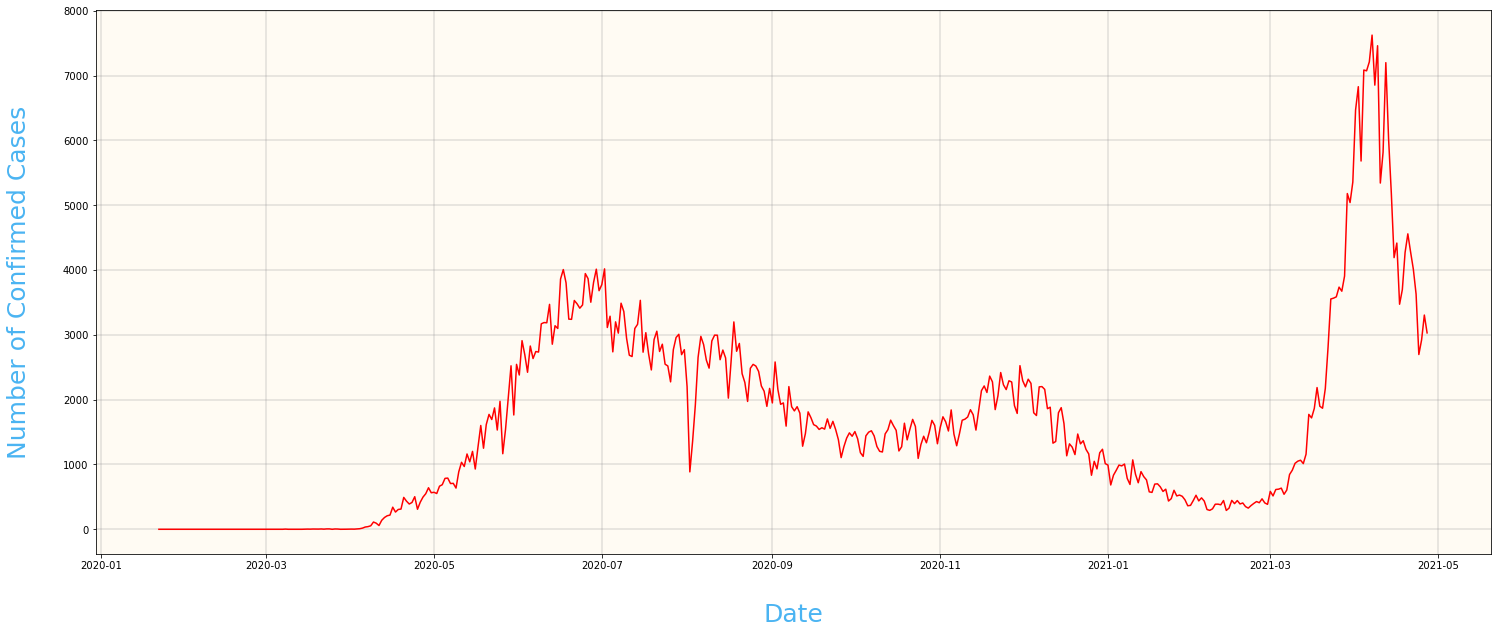

In [16]:
fig, ax=plt.subplots(figsize=(25,10))
ax.grid(linewidth=0.4, color='#8f8f8f') 


ax.plot(df_bd.date,df_bd.daily_case ,color='r', linewidth=1.5)

ax.set_facecolor("#FFFBF3") 
ax.set_xlabel('\nDate',size=25,color='#4bb4f2')
ax.set_ylabel('Number of Confirmed Cases\n',
              size=25,color='#4bb4f2')

In [17]:
bd_monthly=df_bd.groupby([df_bd.date.dt.year,
               df_bd.date.dt.month])['daily_case'].sum()
bd_monthly

date  date
2020  1            0.0
      2            0.0
      3           51.0
      4         7616.0
      5        39486.0
      6        98330.0
      7        92178.0
      8        75335.0
      9        50483.0
      10       44205.0
      11       57248.0
      12       48578.0
2021  1        21629.0
      2        11077.0
      3        65079.0
      4       140364.0
Name: daily_case, dtype: float64

In [18]:
bd_2020=bd_monthly[2020]
bd_2020.index=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bd_2020

Jan        0.0
Feb        0.0
Mar       51.0
Apr     7616.0
May    39486.0
Jun    98330.0
Jul    92178.0
Aug    75335.0
Sep    50483.0
Oct    44205.0
Nov    57248.0
Dec    48578.0
Name: daily_case, dtype: float64

<BarContainer object of 12 artists>

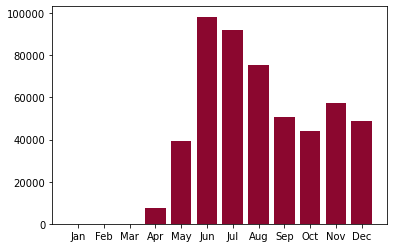

In [22]:
fig, ax=plt.subplots()
#'#003262'
ax.bar(bd_2020.index,bd_2020, color='#8B072F')

In [23]:
bd_2021=bd_monthly[2021]
bd_2021.index=['Jan', 'Feb', 'Mar', 'Apr']
bd_2021

Jan     21629.0
Feb     11077.0
Mar     65079.0
Apr    140364.0
Name: daily_case, dtype: float64

<BarContainer object of 4 artists>

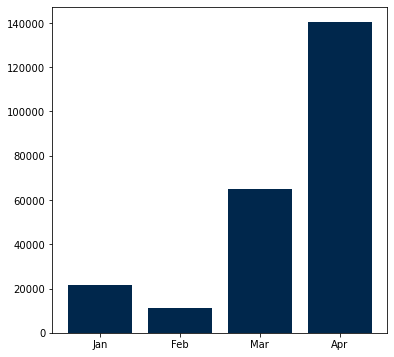

In [24]:
fig, ax=plt.subplots(figsize=(6,6))
ax.bar(bd_2021.index,bd_2021, color='#00274C')